In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [323]:
circuit_name = "Miami"
lap_data = pd.read_csv("./datasets/lapdata/Miami_Grand_Prix.csv")
telem_data = pd.read_csv(f"./datasets/telemetry_data/{circuit_name}_time_series.csv")

In [249]:
driver_id = "VER"

### Track analysis

        lon        lat          x          y
0  7.427191  43.739404   0.000000   0.000000
1  7.427171  43.739494  -2.226390  13.866955
2  7.427199  43.739575   0.890556  26.347232
3  7.427271  43.739686   8.905559  43.449862
4  7.427339  43.739764  16.475285  55.467945


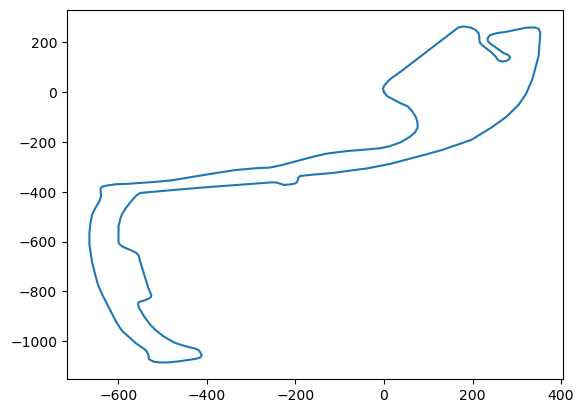

In [37]:
import json

track_name = "Monaco"

# Read data from geojson file
file = open("./datasets/f1-circuits.geojson", "rb")
content = file.read()
tracks_data = json.loads(content)["features"]

# Select track coordinates
select_gp = [x["geometry"]["coordinates"] for x in tracks_data if x["properties"]["Location"] == track_name]
track_data = pd.DataFrame(select_gp[0], columns=["lon", "lat"])


def latlon_to_xy(lat, lon, origin_lat=track_data["lat"][0], origin_lon=track_data["lon"][0]):

    # WGS84 ellipsoid constants
    EARTH_RADIUS = 6378137.0  # Earth's radius in meters
    
    def deg_to_rad(degrees):
        return degrees * (np.pi / 180.0)
    
    # Convert to radians
    lat_rad = deg_to_rad(lat)
    lon_rad = deg_to_rad(lon)
    origin_lat_rad = deg_to_rad(origin_lat)
    origin_lon_rad = deg_to_rad(origin_lon)
    
    # Mercator projection
    x = EARTH_RADIUS * (lon_rad - origin_lon_rad)
    y = EARTH_RADIUS * np.log(
        np.tan(np.pi/4 + lat_rad/2) / 
        np.tan(np.pi/4 + origin_lat_rad/2)
    )
    
    return pd.Series([x, y])

# Convert latlon track coordinates to xy coordinates
track_data[["x", "y"]] = track_data.apply(lambda row: latlon_to_xy(row["lat"], row["lon"]), axis=1)

print(track_data.head())
plt.plot(track_data["x"], track_data["y"])


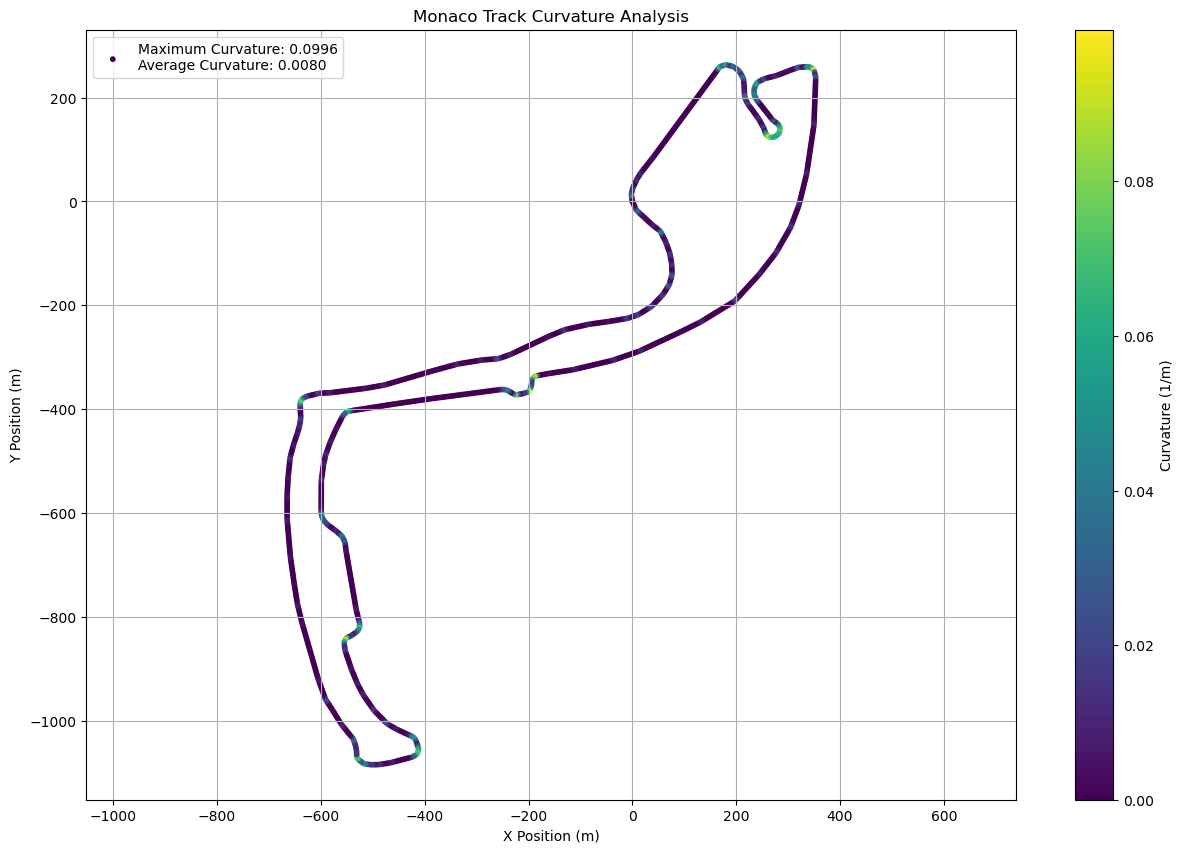

Maximum curvature: 0.0996 m^-1
Average curvature: 0.0080 m^-1
Minimum curvature: 0.0000 m^-1


In [38]:
from scipy.interpolate import splprep, splev

def smooth_track_data(x, y, num_points=1000):

    # Remove duplicate consecutive points
    points = np.column_stack((x, y))
    unique_points = np.vstack([tuple(row) for row in points])
    x, y = unique_points.T
    
    # Fit a B-spline
    tck, u = splprep([x, y], s=0, k=1, per=True)
    
    # Generate points along the smoothed curve
    u_new = np.linspace(0, 1, num_points)
    x_new, y_new = splev(u_new, tck)
    
    return x_new, y_new

def calculate_curvature(x, y):

    # Ensure inputs are numpy arrays
    x = np.array(x)
    y = np.array(y)
    
    # Calculate first derivatives
    dx_dt = np.gradient(x)
    dy_dt = np.gradient(y)
    
    # Calculate second derivatives
    d2x_dt2 = np.gradient(dx_dt)
    d2y_dt2 = np.gradient(dy_dt)
    
    # Calculate curvature using the formula
    curvature = np.abs(dx_dt * d2y_dt2 - dy_dt * d2x_dt2) / (dx_dt**2 + dy_dt**2)**(3/2)
    
    return curvature

def plot_track_curvature(x, y, curvature):

    plt.figure(figsize=(15, 10))
    
    # Plot track colored by curvature
    points = plt.scatter(x, y, c=curvature, cmap='viridis', 
                        s=10, 
                        label=f'Maximum Curvature: {np.max(curvature):.4f}\nAverage Curvature: {np.mean(curvature):.4f}'
            )
    plt.colorbar(points, label='Curvature (1/m)')
    plt.legend()
    plt.title(f'{track_name} Track Curvature Analysis')
    plt.xlabel('X Position (m)')
    plt.ylabel('Y Position (m)')
    plt.axis('equal')
    plt.grid(True)
    plt.show()


x_smooth, y_smooth = smooth_track_data(track_data["x"].values, track_data["y"].values)

curvature = calculate_curvature(x_smooth, y_smooth)

plot_track_curvature(x_smooth, y_smooth, curvature)

print(f"Maximum curvature: {np.max(curvature):.4f} m^-1")
print(f"Average curvature: {np.mean(curvature):.4f} m^-1")
print(f"Minimum curvature: {np.min(curvature):.4f} m^-1")


### Telemetry data analysis

In [324]:
driver_laps = lap_data.loc[lap_data["Driver"] == driver_id]
driver_race_time = pd.to_datetime(driver_laps["LapTime"].sum(), unit="s").time()
driver_laps = driver_laps.set_index(pd.to_datetime(driver_laps["LapStartDate"])).drop(["LapStartDate"], axis=1)
print(driver_race_time)
print(driver_laps.head())

01:28:22.455000
                         DriverNumber Driver  LapNumber Compound  TyreLife  \
LapStartDate                                                                 
2024-05-05 20:03:23.796             1    VER        1.0   MEDIUM       1.0   
2024-05-05 20:04:58.417             1    VER        2.0   MEDIUM       2.0   
2024-05-05 20:06:31.510             1    VER        3.0   MEDIUM       3.0   
2024-05-05 20:08:04.647             1    VER        4.0   MEDIUM       4.0   
2024-05-05 20:09:38.151             1    VER        5.0   MEDIUM       5.0   

                         Sector1Time  Sector2Time  Sector3Time  LapTime  \
LapStartDate                                                              
2024-05-05 20:03:23.796          NaN       34.990       26.211   94.338   
2024-05-05 20:04:58.417       31.455       35.489       26.149   93.093   
2024-05-05 20:06:31.510       31.551       35.472       26.114   93.137   
2024-05-05 20:08:04.647       31.508       35.686       26.310

In [325]:
print(telem_data.head())
driver_telemetry = telem_data.loc[telem_data["Driver"] == driver_id] \
        [["Date", "RPM", "Speed", "nGear", "Throttle", "Brake", "DRS"]]

driver_telemetry = driver_telemetry \
            .set_index(pd.to_datetime(driver_telemetry["Date"])).drop(["Date"], axis=1)

driver_telemetry.head(n=10)

                      Date   RPM  Speed  nGear  Throttle  Brake  DRS  \
0  2024-05-05 20:03:23.796  9517      0      1        19   True    1   
1  2024-05-05 20:03:23.810  9509      0      1        19   True    1   
2  2024-05-05 20:03:23.824  9322      0      1        19   True    1   
3  2024-05-05 20:03:24.024  9135      0      1        19   True    1   
4  2024-05-05 20:03:24.170  8949      0      1        19   True    1   

                     Time             SessionTime  DriverAhead  \
0         0 days 00:00:00  0 days 00:55:43.028000          NaN   
1  0 days 00:00:00.014000  0 days 00:55:43.042000          NaN   
2  0 days 00:00:00.028000  0 days 00:55:43.056000          NaN   
3  0 days 00:00:00.228000  0 days 00:55:43.256000          NaN   
4  0 days 00:00:00.374000  0 days 00:55:43.402000          NaN   

   DistanceToDriverAhead     X    Y  LapNumber  TrackStatus  DriverNumber  \
0                    0.0  2551 -320        1.0            1             4   
1               

,RPM,Speed,nGear,Throttle,Brake,DRS
Date,,,,,,
2024-05-05 20:03:23.796,10138,0,1,15,True,1
2024-05-05 20:03:23.810,10082,0,1,15,True,1
2024-05-05 20:03:23.824,10128,0,1,15,True,1
2024-05-05 20:03:24.024,10174,0,1,15,True,1
2024-05-05 20:03:24.170,10221,0,1,15,True,1
2024-05-05 20:03:24.324,9101,5,1,15,True,1
2024-05-05 20:03:24.530,7981,10,1,15,False,1
2024-05-05 20:03:24.604,7001,13,1,15,False,1
2024-05-05 20:03:24.810,6021,16,1,16,False,1


In [332]:
################ Merge race data with telemetry data ################

select_lap_data = driver_laps[["LapNumber", "TrackStatus", "Compound", "TyreLife"]]

additional_columns = ["TrackStatus", "Compound"]

lap_times = select_lap_data.index
lap_numbers = select_lap_data['LapNumber']

# Initialize lap column
result_df = driver_telemetry.copy()
result_df['LapNumber'] = None

# Assign lap numbers
for i in range(len(lap_times)-1):
    current_lap_start = lap_times[i]
    next_lap_start = lap_times[i+1]
    current_lap_number = lap_numbers.iloc[i]
    
    # Assign lap number to all rows between current and next lap start
    mask = (result_df.index >= current_lap_start) & (result_df.index < next_lap_start)
    result_df.loc[mask, 'LapNumber'] = current_lap_number

    for col in additional_columns:
        result_df.loc[mask, col] = select_lap_data[col].iloc[i]

# Handle last lap
last_lap_mask = result_df.index >= lap_times[-1]
result_df.loc[last_lap_mask, 'LapNumber'] = lap_numbers.iloc[-1]

# Handle additional columns for last lap
for col in additional_columns:
    result_df.loc[last_lap_mask, col] = select_lap_data[col].iloc[-1]

driver_telemetry = result_df.copy()

driver_telemetry.head()
select_lap_data.loc[select_lap_data["TrackStatus"] != 1.0]

,LapNumber,TrackStatus,Compound,TyreLife
LapStartDate,,,,
2024-05-05 20:37:31.386,23.0,167,MEDIUM,23.0
2024-05-05 20:45:47.634,28.0,124,HARD,5.0
2024-05-05 20:47:27.010,29.0,4,HARD,6.0
2024-05-05 20:49:53.529,30.0,4,HARD,7.0
2024-05-05 20:51:57.949,31.0,4,HARD,8.0
2024-05-05 20:53:39.026,32.0,41,HARD,9.0


Text(0.5, 1.0, 'Timeseries data sampling step')

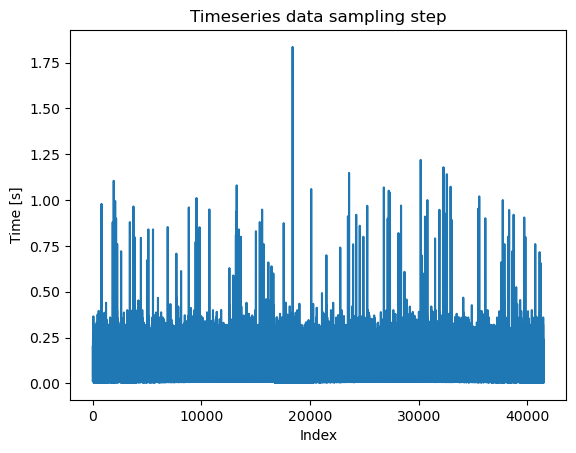

In [327]:
########### Check data sampling step ###########
DT = (driver_telemetry.index[1:] - driver_telemetry.index[:-1]).total_seconds()
plt.plot(np.arange(len(driver_telemetry.index[:-1])), DT)
plt.ylabel("Time [s]")
plt.xlabel("Index")
plt.title("Timeseries data sampling step")

                         LapNumber  TrackStatus Compound  TyreLife
LapStartDate                                                      
2024-05-05 20:03:23.796        1.0            1   MEDIUM       1.0
2024-05-05 20:04:58.417        2.0            1   MEDIUM       2.0
2024-05-05 20:06:31.510        3.0            1   MEDIUM       3.0
2024-05-05 20:08:04.647        4.0            1   MEDIUM       4.0
2024-05-05 20:09:38.151        5.0            1   MEDIUM       5.0
               Speed  Acceleration
LapNumber                         
1.0        54.639207      5.415288
2.0        57.551010      5.258823
3.0        57.391650      5.336117
4.0        57.247138      5.273369
5.0        57.497290      5.320976


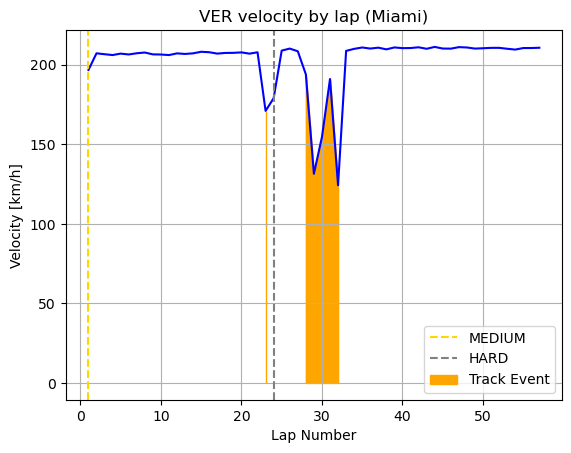

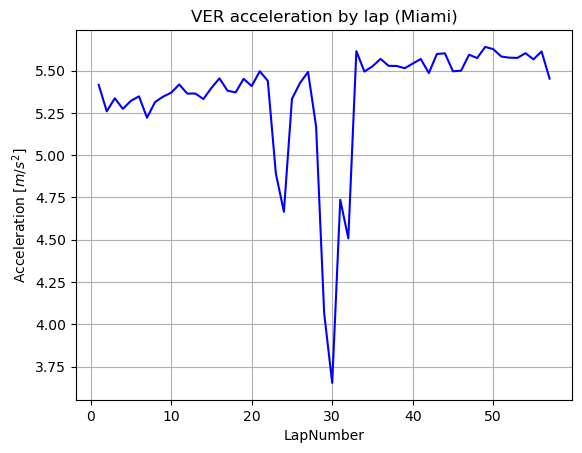

In [335]:
car_data = pd.DataFrame(
    {
        "Speed": driver_telemetry["Speed"].values / 3.6, # convert from km/h to m/s
        "LapNumber": driver_telemetry["LapNumber"].values
    },
    index = driver_telemetry.index
)

########### Resample and aggregate selected data ###########

downsampled_groups = []
for lap, lap_data in car_data.groupby('LapNumber'):
    lap_downsampled = lap_data.resample('1S').agg({
        'Speed': 'mean',
        'LapNumber': 'first'
    })
    
    downsampled_groups.append(lap_downsampled)

resampled_car_data = pd.concat(downsampled_groups).sort_index()

########### Calculate car acceleration ###########

dt = 1.0
#acceleration = abs(resampled_car_data["Speed"].values[1:] - resampled_car_data["Speed"].values[:-1]) / dt
#acceleration = np.insert(acceleration, 0, 0.0)
acceleration = np.abs(np.gradient(resampled_car_data["Speed"].values))

resampled_car_data["Acceleration"] = acceleration


########### Calculate and display car mean velocity and acceleration by lap ###########

compound_colors = {
    'SOFT': 'red',
    'MEDIUM': 'gold',
    'HARD': 'gray',
    'INTERMEDIATE': 'green',
    'WET': 'blue'
}


print(select_lap_data.head())


car_data_by_lap = resampled_car_data.groupby("LapNumber").mean()
print(car_data_by_lap.head())

plt.figure()

lap_compounds = select_lap_data["Compound"].values
laps_tyre_life = select_lap_data["TyreLife"].values
track_statuses = select_lap_data["TrackStatus"].values
current_compound = lap_compounds[0]
start_event_region = -1
end_event_region = -1

# Plot velocity
plt.plot(np.arange(1, len(car_data_by_lap["Speed"])+1), car_data_by_lap["Speed"].values * 3.6, c='blue')

# Plot tire changes
plt.axvline(x=select_lap_data["LapNumber"].values[0], color=compound_colors[current_compound], linestyle='--', label=f"{current_compound}")
for i in range(len(lap_compounds)):
    if i < len(lap_compounds) - 1 and laps_tyre_life[i] >= laps_tyre_life[i + 1]:
        current_compound = lap_compounds[i + 1]
        plt.axvline(x=select_lap_data["LapNumber"].values[i+1], color=compound_colors[current_compound], linestyle='--', label=f"{current_compound}")

    if start_event_region == -1 and track_statuses[i] != 1.0:
        start_event_region = i
    elif track_statuses[i] == 1.0 and track_statuses[i-1] != 1.0:
        end_event_region = i
        plt.fill_between(np.arange(start=start_event_region+1, stop=end_event_region+1), car_data_by_lap["Speed"].values[start_event_region:end_event_region] * 3.6, color='orange', label="Track Event")
        start_event_region = -1
        end_event_region = -1


plt.xlabel("Lap Number")
plt.ylabel("Velocity [km/h]")
plt.title(f"{driver_id} velocity by lap ({circuit_name})")
plt.grid()
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.figure()
plt.plot(np.arange(1, len(car_data_by_lap["Acceleration"])+1), car_data_by_lap["Acceleration"].values, c='blue')
plt.xlabel("LapNumber")
plt.ylabel(r"Acceleration [$m/s^2$]")
plt.title(f"{driver_id} acceleration by lap ({circuit_name})")
plt.grid()

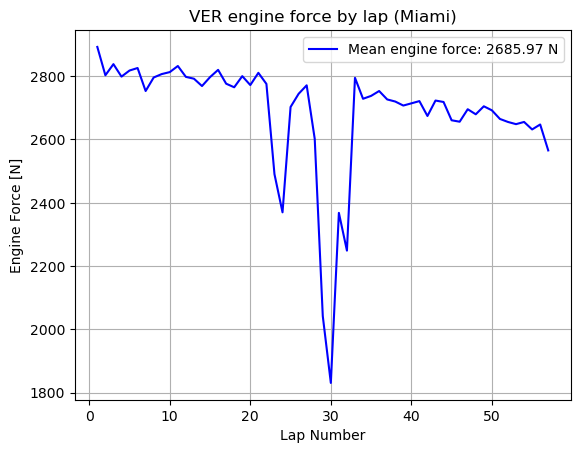

In [334]:
########### Calculate and display mean car engine force by lap ###########

m_car = 798
m_fuel = 110
mu = 1.7

n_laps = len(car_data_by_lap)
m_total = m_car + m_fuel
fuel_consumption = m_fuel / n_laps # Linear fuel consuption by each lap

engine_force_data = []
for accel in car_data_by_lap["Acceleration"].values:
    engine_force_data.append((m_total * accel) / mu)
    m_fuel -= fuel_consumption
    m_total = m_car + m_fuel

car_data_by_lap["EngineForce"] = engine_force_data

plt.figure()
plt.plot(np.arange(1, len(car_data_by_lap["EngineForce"])+1), car_data_by_lap["EngineForce"].values, label=f"Mean engine force: {np.mean(engine_force_data):.2f} N", c='blue')
plt.xlabel("Lap Number")
plt.ylabel("Engine Force [N]")
plt.title(f"{driver_id} engine force by lap ({circuit_name})")
plt.legend()
plt.grid()


### Testing section

Text(0.5, 1.0, 'Friction by lap')

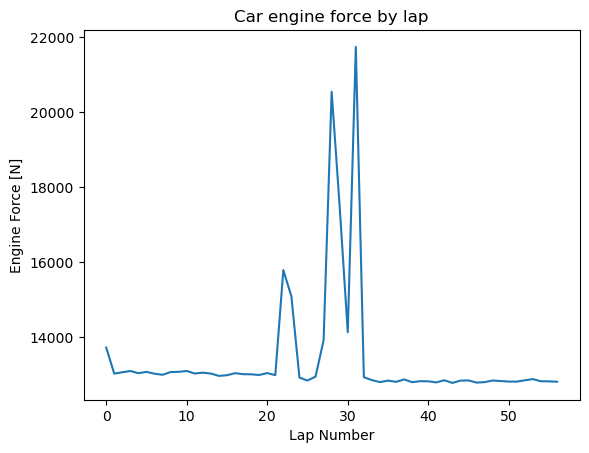

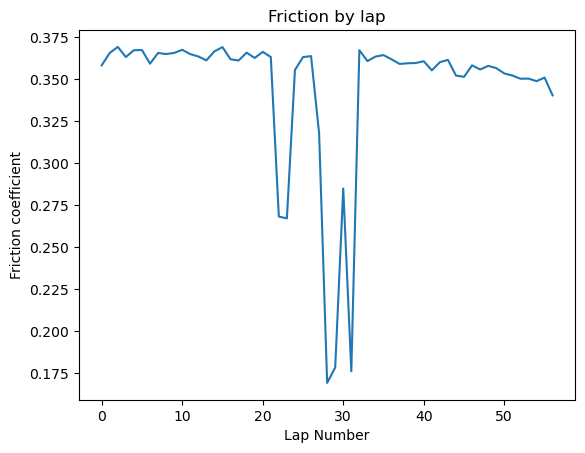

In [333]:
########### Calculate and display mean car engine force by lap ###########

m_car = 798
m_fuel = 110
mu = 1.7
red_bull_car_power = 750000 # In Watts

car_data_by_lap["EngineForce"] = red_bull_car_power / car_data_by_lap["Speed"]

m_total = m_car + m_fuel
fuel_consumption = m_fuel / len(car_data_by_lap) # Linear fuel consuption by each lap

car_friction_data = []
for accel, engine_force in zip(car_data_by_lap["Acceleration"].values, car_data_by_lap["EngineForce"].values):
    car_friction_data.append((m_total * accel) / engine_force)
    m_fuel -= fuel_consumption
    m_total = m_car + m_fuel

car_data_by_lap["FrictionCoeff"] = car_friction_data

plt.figure()
plt.plot(np.arange(len(car_data_by_lap["EngineForce"])), car_data_by_lap["EngineForce"].values)
plt.xlabel("Lap Number")
plt.ylabel("Engine Force [N]")
plt.title("Car engine force by lap")
plt.figure()
plt.plot(np.arange(len(car_data_by_lap["FrictionCoeff"])), car_data_by_lap["FrictionCoeff"].values)
plt.xlabel("Lap Number")
plt.ylabel("Friction coefficient")
plt.title("Friction by lap")
